# Figsetup
Using chou 20210513 unsort data Ch9.<br>
shortcaption: <br>
label: NGD1d_repro_iP_simulation

In [1]:
filename = 'NGD1d_repro_iP_simulation'

# Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import SG
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS
from NGD_TK_AS import ParaTrans

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


In [4]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [5]:
def cm2inch(value):
    return value/2.54

# Load Experimental data

In [6]:
dt = 0.01
cn = 53

file_list = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=2_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=4_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=7_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=10_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_original_tau=0p5_sort_unit2']
x_list = []
T_list = []
rstate_list = []
for file in file_list:
    annots = loadmat(file, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect') / dt
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x -np.mean(x))/np.std(x)
    T = np.arange(len(x)+1)*dt
    rstate,_ = np.histogram(annots['Spikes'][cn-1]-TimeStamps[0], T)
    rstate_list.append( rstate.copy() )
    x_list.append( x.copy() )
    T_list.append( T.copy() )

In [7]:
cstax_list, cstaT_list, cstarstate_list = expSnR(['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_cSTA_sort_unit2'], dt, 'LED', np.arange(60)+1)
x = cstax_list[0]
x = x-np.mean(x)/np.std(x)

rstate = cstarstate_list[0][cn-1,:]

cSTA = np.correlate(x, rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
LEDtaxis = taxis
LEDcSTA = cSTA

NGD2L1DASpara = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]

# Real STA 

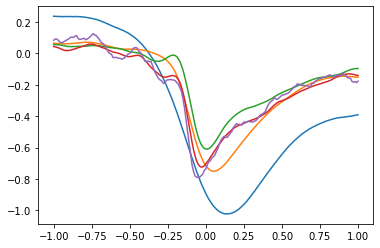

In [8]:
Xcorr_list = []
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt
real_sta_min = []
for i in range(len(x_list)):
    Xcorr = np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    plt.plot(timeaxis, Xcorr)
    real_sta_min.append( np.min(Xcorr) )

# TK

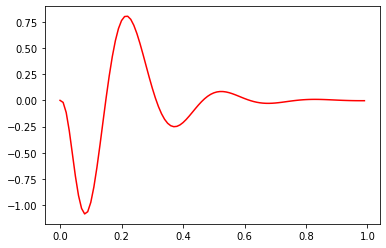

In [9]:
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513'
NGD2L1DASpara = np.load(exp_folder + '\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]
cn = 9
pd.DataFrame(para_dict).loc[cn-1]

Ktaxis = np.arange(0, 1., dt)
Kt = NGD2L_TK_AS(Ktaxis, *pd.DataFrame(para_dict).loc[cn-1][:-1])
plt.plot(Ktaxis, Kt, 'r')

# plt.plot(-LEDtaxis, cSTA, 'b+:')

In [10]:
pd.DataFrame(para_dict).loc[cn-1][:-1]

epsilon       7.163241
gamma        34.901452
omegastar    20.631698
deltastar    -0.450280
tau_y         0.028650
Dmp           3.389743
Name: 8, dtype: float64

(0.0, 20.0)

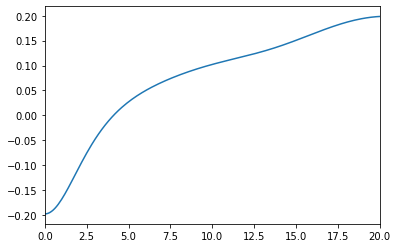

In [11]:
df = 0.1
faxis = np.arange(-50,50,df)

F_TK = np.sum(Kt[np.newaxis,:]*np.exp(-1j*Ktaxis[np.newaxis,:]*faxis[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/df
plt.plot(faxis, delta)
plt.xlim([0,20])

# Model Spike 

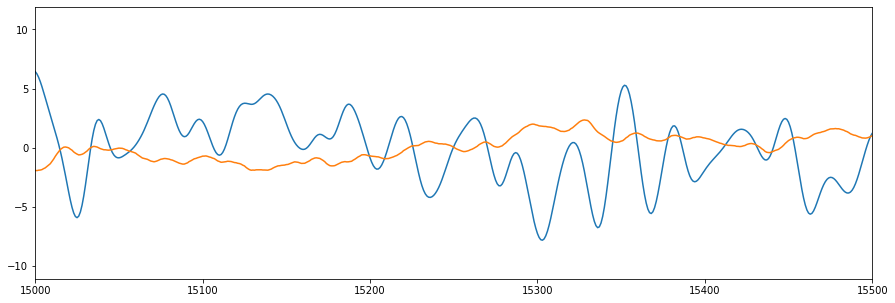

In [12]:
w_list = [np.convolve(x, Kt, 'full')[:len(x)]*dt for x in x_list]
i=3
plt.plot(w_list[i]*60)
plt.plot(x_list[i])

plt.xlim([15000, 15500])
plt.gcf().set_size_inches(15,5)

# fit theta by min(STA)

In [40]:
# STA is normalized cross-correlation (to firing rate)
# So it's non-sensitive to r_mean
fitted_theta_star_list = [0]*len(x_list)
# for i in range(len(x_list)):
#     window = [-1,1] # second
#     timeaxis = np.arange(-100,101)*dt
#     sta_min = []
#     thetas = np.linspace(-1.5, 1.5, 20)
#     w = w_list[i]
#     for theta_star in thetas:
#         r = NL(w, np.mean(w)+theta_star*np.std(w))
#         Xcorr = np.correlate(x_list[i], r, 'same')/ np.correlate(np.ones_like(x_list[i]), r, 'same')
#         Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
#         sta_min.append( min(Xcorr) )

#     plt.plot( thetas*np.std(w)+np.mean(w) , sta_min)
#     fitted_theta = np.interp(real_sta_min[i], sta_min[::-1], thetas[::-1]*np.std(w)+np.mean(w) )
#     plt.scatter(fitted_theta, real_sta_min[i]) 
#     fitted_theta_star = ( fitted_theta-np.mean(w) ) /np.std(w)
#     fitted_theta_star_list[i] =  fitted_theta_star.copy() 
# fitted_theta_star_list

In [41]:
NLw_list = [0]*len(x_list)
wstate_list = [0]*len(x_list)
for i in range(len(x_list)):
    NLw_list[i] = NL(w_list[i], np.mean(w_list[i])+fitted_theta_star_list[i]*np.std(w_list[i]))
    wstate_list[i], _ = np.histogram( Spike_Time_Generater( NLw_list[i] , dt, 2, 10), T_list[i])

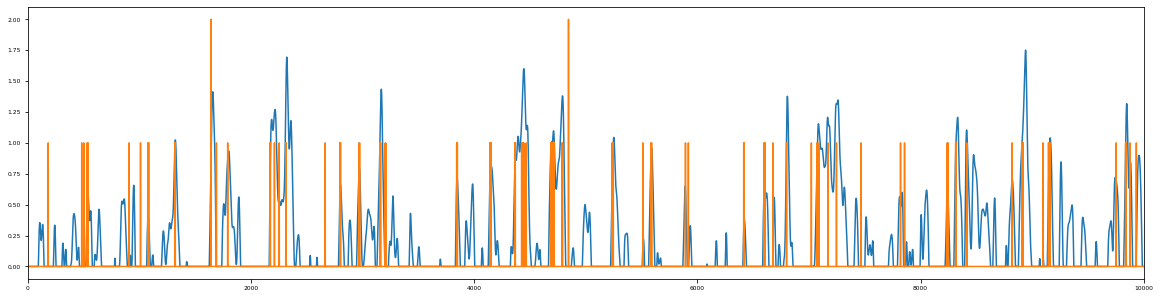

In [42]:
i=0
plt.plot(NLw_list[i] /max(NLw_list[i]) *2)
# plt.plot(NLw_list[i] /sum(NLw_list[i]) *sum(rstate_list[i]))
# plt.plot(wstate_list[i])
plt.plot(rstate_list[i])

# plt.xlim([0, 29000])
plt.xlim([0, 10000])
# plt.ylim([0, 2])
plt.gcf().set_size_inches(20,5)

# model STA

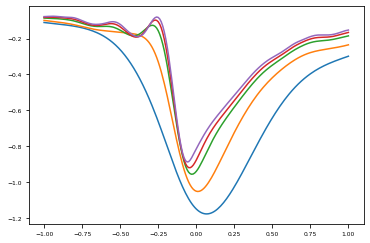

In [43]:
model_Xcorr_list = []
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt
for i in range(len(x_list)):
    model_Xcorr = np.correlate(x_list[i], NLw_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), NLw_list[i], 'same')
    model_Xcorr = model_Xcorr[int(len(model_Xcorr)/2)-100 : int(len(model_Xcorr)/2)+101]
    model_Xcorr_list.append( model_Xcorr.copy() )
for i in range(len(x_list)):
    plt.plot(timeaxis, model_Xcorr_list[i])

# model MI PID

In [44]:
tv_list = [ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt  for x in x_list]
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

In [45]:
window = [-1,1] # second
Information_list = [0]*len(x_list)
i = 0
timeshift, Information_list[i] = PIfunc(wstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

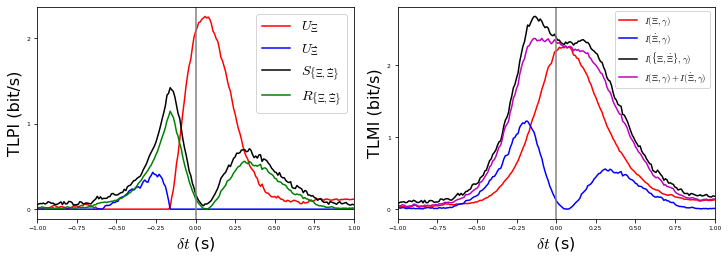

In [46]:
plt.rcParams["font.size"] = 8

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)

# Final Fig. 

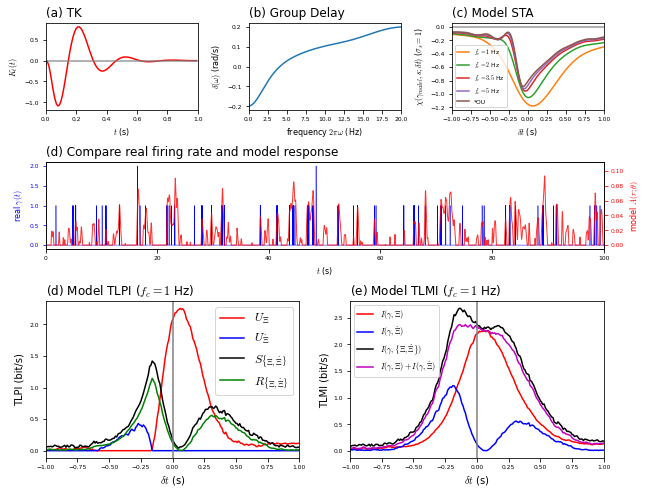

In [49]:
plt.rcParams["font.size"] = 8
plt.rcParams['xtick.labelsize'] =  6
plt.rcParams['ytick.labelsize'] =  6

fig = plt.figure()
axgird = fig.add_gridspec(7, 6, wspace=1.0, hspace=3.0)

axa = plt.subplot(axgird[:2,:2])
# axa.plot(-LEDtaxis, cSTA, 'b+:')
axa.plot(Ktaxis, Kt, 'r')
axa.set_xlim([0,1])
axa.set_xlabel(r'$t$ (s)')
axa.set_ylabel(r'$K_t(t)$')
axa.set_title('(a) TK', loc = 'left', fontsize = 12)
axa.axhline(0, c = 'gray', alpha = 0.8)
# axa.legend( (r'measured $K_t(-\delta t)$', r'fitted $(K_{Delay}*K_w)(-\delta t)$'), fontsize = 8)

axb = plt.subplot(axgird[:2,2:4])
axb.plot(faxis, delta)
axb.set_xlim([0,20])
axb.set_xlabel(r'frequency $2\pi\omega$ (Hz)')
axb.set_ylabel(r'$\delta(\omega)$ (rad/s)')
axb.set_title('(b) Group Delay', loc = 'left', fontsize = 12)

axc = plt.subplot(axgird[:2,4:6])
for i in range(len(x_list)):
    axc.plot(timeaxis, model_Xcorr_list[i], c= plt.cm.tab10(i+1))
axc.set_xlim(window)
axc.set_ylabel(r'$\chi(\gamma_{model}, s; \delta t)$ ($\sigma_s=1$)')
axc.set_xlabel(r'$\delta t$ (s)')
axc.set_title('(c) Model STA', loc = 'left', fontsize = 12)
axc.axhline(0, c = 'gray', alpha = 0.8)
axc.legend( (r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=3.5$ Hz', r'$f_c=5$ Hz', r'*OU'),  fontsize = 6 )

axd = plt.subplot(axgird[2:4,:])
i=0
axd.plot(T_list[i][:-1], rstate_list[i], 'b', linewidth = 0.5)
# plt.bar(T_list[i][:1000]+0.5*dt, rstate_list[i][:1000], width = dt)
axd.tick_params(axis='y', colors='b')
axd.set_ylabel(r'real $\gamma(t)$', color='b')
axdd = axd.twinx()
axdd.plot(T_list[i][:-1], NLw_list[i], 'r', linewidth = 1, alpha = 0.8)
axdd.tick_params(axis='y', colors='r')
axdd.set_ylabel(r'model $A(r; \theta)$', color='r')
axd.set_xlim([0, 100])
axd.set_xlabel(r'$t$ (s)')
# axd.set_xticks([])
axd.set_title('(d) Compare real firing rate and model response', loc = 'left', fontsize = 12)

plt.rcParams["font.size"] = 10

axe = plt.subplot(axgird[4:,:3])
axe.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
axe.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
axe.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
axe.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
axe.set_xlabel(r'$\delta t$ (s)')
axe.set_ylabel('TLPI (bit/s)')
axe.axvline(0, c = 'gray')
axe.set_xlim(window)
axe.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'),loc='best', prop={'size': 12})
axe.set_title(r'(d) Model TLPI ($f_c=1$ Hz)', loc = 'left', fontsize = 12)

axf = plt.subplot(axgird[4:,3:])
axf.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
axf.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
axf.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
axf.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
axf.set_xlabel(r'$\delta t$ (s)')
axf.set_ylabel('TLMI (bit/s)')
axf.axvline(0, c = 'gray')
axf.set_xlim(window)
axf.legend( (r'$I(\gamma,\Xi)$', r'$I(\gamma,\dot\Xi)$', r'$I(\gamma,\{\Xi,\dot\Xi\})$', r'$I(\gamma,\Xi)+I(\gamma,\dot\Xi)$'),
           loc='best', prop={'size': 8})
axf.set_title(r'(e) Model TLMI ($f_c=1$ Hz)', loc = 'left', fontsize = 12)

fig.set_size_inches(10, 8)
fig.tight_layout()

In [50]:
fig.savefig('D:\\GoogleDrive\\retina\\thesis\\fig\\R\\'+filename+'.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)